In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy import stats
from math import atan,sin,cos
from scipy.signal import find_peaks

## 1. import the data

- reading from csv file
- centering the data
## 2. hough trensform the points

- column 1: x-coordinate
- column 2: y-coordinate
- column 3: i_th_point
- column 4: j_th_point

## 3. finding the theta peaks in hough space

- $$\theta = \arg \max_{x}KDE(\theta)$$

## 4. using the top two of KDE values as the new basis, transform the origin points into new points

In [ ]:
def hough_transform(points):

    centre = np.mean(points,axis=0)
    points_num  = points.shape[0]
    row_transformed_data = int(points_num*(points_num-1)/2)
    hough_space = np.zeros(shape=(row_transformed_data,4))

    for i in range(points_num):
        for j in range(i+1,points_num):
            idx = int(i*points_num - i*(i+1)/2+j-i-1)

            x_i,y_i = points[i]-centre
            x_j,y_j = points[j]-centre

            theta = atan((x_j-x_i)/(y_i-y_j))
            
            rho = x_i*cos(theta)+y_i*sin(theta)
            
            hough_space[idx][0] = theta
            hough_space[idx][1] = rho
            hough_space[idx][2] = i
            hough_space[idx][3] = j

    return hough_space

def find_kde_peaks(data,bw = 0.05):
    
    """
    returns: m x 2 NDarray\\
    column 0: value from data corrsponding to the peak_kde_values\\
    column 1: peak kde values

    """

    kde = stats.gaussian_kde(data,bw_method=bw)

    x_range = np.linspace(-2,2,1000)
    kde_values = kde(x_range)

    peaks,_ = find_peaks(kde_values)
    
    x_peaks = x_range[peaks].reshape(-1,1)
    kde_values_peaks = kde_values[peaks].reshape(-1,1)

    kde_peaks = np.hstack((x_peaks, kde_values_peaks))

    return kde_peaks

def find_top_two_kde_peaks(kde_peaks):

    sorted_indices = np.argsort(kde_peaks[:,1])[::-1]
    top_two_indices = sorted_indices[:2]
    top_two_kde_peaks = kde_peaks[top_two_indices]

    return top_two_kde_peaks

def transform_along_basis(points, basis_i, basis_j):

    transformed_points = []

    for point in points:
        # 计算点在基向量上的投影系数
        coeff_i = np.dot(point, basis_i) / np.dot(basis_i, basis_i)
        coeff_j = np.dot(point, basis_j) / np.dot(basis_j, basis_j)
        transformed_points.append((coeff_i, coeff_j))

    return np.array(transformed_points)

def calculate_nearest_location(points, grids_x_axes, grids_y_axes):

    nearest_grids = []

    for pt in points:
        x_min_idx = (np.square(grids_x_axes - pt[0])).argmin()
        y_min_idx = (np.square(grids_y_axes - pt[1])).argmin()

        nearest_grids.append((x_min_idx, y_min_idx))

    nearest_grids = np.array(nearest_grids)

    while True:

        unique_grids,counts = np.unique(nearest_grids, axis=0, return_counts=True)
        repeated_grids = unique_grids[counts>1]
        
        if len(repeated_grids) == 0:
            break
        for rep_grid in repeated_grids:
            indices = np.where((nearest_grids == rep_grid).all(axis=1))[0]

            idx_pt_a,idx_pt_b = indices[0],indices[1]

            idx_grid_i,idx_grid_j = rep_grid[0],rep_grid[1]

            pt_a, pt_b = points[idx_pt_a],points[idx_pt_b]

            grid_i,grid_j = grids_x_axes[idx_grid_i],grids_y_axes[idx_grid_j]

            # pt_a x values less than pt_b, then change the pt_b's nearest girds
            if pt_a[0] < pt_b[0]:

                x_to_grid_dist = np.square(pt_b[0]-grid_i)
                y_to_grid_dist = np.square(pt_b[1]-grid_j)

                if x_to_grid_dist < y_to_grid_dist:
                    new_nearest_grid = [idx_grid_i,idx_grid_j+1]
                else:
                    new_nearest_grid = [idx_grid_i+1,idx_grid_j]

                nearest_grids[idx_pt_b] = new_nearest_grid
            else:

                x_to_grid_dist = np.square(pt_a[0]-grid_i)
                y_to_grid_dist = np.square(pt_a[1]-grid_j)

                if x_to_grid_dist < y_to_grid_dist:
                    new_nearest_grid = [idx_grid_i,idx_grid_j+1]
                else:
                    new_nearest_grid = [idx_grid_i+1,idx_grid_j]

                nearest_grids[idx_pt_a] =new_nearest_grid

    return nearest_grids

In [ ]:
points = np.genfromtxt("./soucefile/coords.csv", delimiter=",")

# step-1: finding the top two theta
hough_space = hough_transform(points)

hough_space_theta = hough_space[:,0]
hough_space_rho = hough_space[:,1]

theta_kde_peaks = find_kde_peaks(hough_space_theta)
top_two_kde_peaks = find_top_two_kde_peaks(theta_kde_peaks)

theta_1 = top_two_kde_peaks[0,0]
theta_2 = top_two_kde_peaks[1,0]

# step-2: transform the orginal data along the new basis
basis_i = np.array([cos(theta_1),sin(theta_1)])
basis_j = np.array([cos(theta_2),sin(theta_2)])

transformed_points = transform_along_basis(points,basis_i,basis_j)

# step-3: finding the grid
grids_i_axes = find_kde_peaks(transformed_points[:,0])[:,0]

grid_j_axes = find_kde_peaks(transformed_points[:,1])[:,0]

# step-4: set the points into the grid
nearest_grids = calculate_nearest_location(transformed_points,grids_i_axes,grid_j_axes)

--- 

这是一条分割线




---

In [3]:
points = np.genfromtxt("./soucefile/coords.csv", delimiter=",")
centre = np.mean(points, axis=0)
points_centered = points - centre

In [4]:
points_len=len(points_centered)

points_hough_len=int(points_len*(points_len-1)/2)

points_hough = np.zeros(shape=(points_hough_len,4))

# calculate hough space
for i in range(points_len):
    for j in range(i+1,points_len):
        idx = int(i*points_len - i*(i+1)/2+j-i-1)

        x_i,y_i = points[i]-centre
        x_j,y_j = points[j]-centre

        theta = atan((x_j-x_i)/(y_i-y_j))
        
        rho = x_i*cos(theta)+y_i*sin(theta)

        points_hough[idx][0] = theta
        points_hough[idx][1] = rho
        points_hough[idx][2] = i
        points_hough[idx][3] = j

points_hough_x = points_hough[:,0]
points_hough_y = points_hough[:,1]

<Axes: ylabel='Count'>

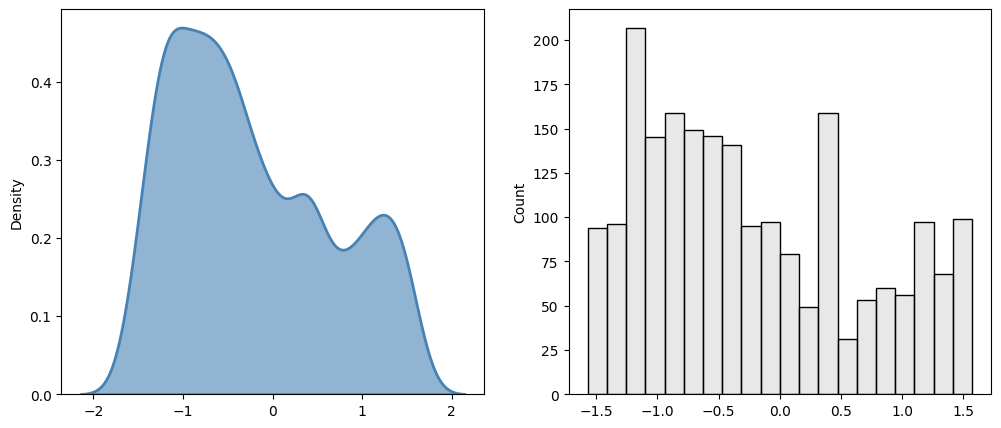

In [5]:
# visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(points_hough_x, fill=True, color="steelblue", alpha=0.6, linewidth=2,ax=ax1)
sns.histplot(points_hough_x, bins=20, kde=False, color="lightgray", alpha=0.5,ax=ax2)

In [6]:
# visualization

kde = stats.gaussian_kde(points_hough_x,bw_method=0.05)
x = np.linspace(-2, 2, 1000)
y = kde(x)

peaks, _ = find_peaks(y)
peak_x = x[peaks]
peak_y = y[peaks]

# 可视化
plt.figure(figsize=(15,15),dpi=600)
plt.plot(x, y, 'b-', label='KDE', linewidth=2)
plt.scatter(peak_x, peak_y, color='red', s=100, zorder=5, label='峰值点')

# 标注峰值坐标
for i, (px, py) in enumerate(zip(peak_x, peak_y)):
    plt.annotate(f'({px:.2f}, {py:.2f})', 
                 xy=(px, py), 
                 xytext=(px+0.2, py+0.02),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=10)

plt.xlabel('x')
plt.ylabel('密度')
plt.title('KDE密度估计与峰值检测')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 输出结果
print("检测到的峰值:")
for i, (x_val, y_val) in enumerate(zip(peak_x, peak_y)):
    print(f"峰值 {i+1}: x = {x_val:.3f}, 密度 = {y_val:.3f}")

/opt/miniconda3/envs/stratumodel/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/stratumodel/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/stratumodel/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20272 (\N{CJK UNIFIED IDEOGRAPH-4F30}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/stratumodel/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/stratumodel/lib/python3.10/site-packages/IPython/core/pylabtools.py

检测到的峰值:
峰值 1: x = -1.427, 密度 = 0.310
峰值 2: x = -1.223, 密度 = 0.709
峰值 3: x = -0.799, 密度 = 0.487
峰值 4: x = -0.410, 密度 = 0.478
峰值 5: x = -0.090, 密度 = 0.313
峰值 6: x = 0.406, 密度 = 0.602
峰值 7: x = 0.823, 密度 = 0.193
峰值 8: x = 1.163, 密度 = 0.296
峰值 9: x = 1.451, 密度 = 0.292


In [ ]:
# visualization

plt.figure(figsize=(15,15),dpi=600)
# add vertical lines
vlines_x = np.arange(-1.6,1.6,0.1)
for vline_x in vlines_x:
    vline_x = float(vline_x)
    plt.axvline(x=vline_x, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)
plt.scatter(points_hough_x, points_hough_y,s=5)

In [8]:
def get_line_by_angle(angle_radians, x_min, x_max, **kwargs):
    """
    绘制指定角度的直线
    
    参数:
    angle_radians: 弧度
    x_range: x轴范围
    **kwargs: 传递给plot的参数
    """

    
    # 计算斜率
    slope = np.tan(angle_radians)
    
    # 生成x值
    x = np.linspace(x_min, x_max, 100)
    
    # 计算对应的y值（通过原点）
    y = slope * x
    
    # 绘制直线
    
    return x,y

In [9]:
rad1 = -1.223
rad2 = 0.406

points_centered_x_min = np.min(points_centered[:,0])
points_centered_x_max = np.max(points_centered[:,0])

angle_1_x,angle_1_y = get_line_by_angle(rad1,points_centered_x_min,points_centered_x_max)
angle_2_x,angle_2_y = get_line_by_angle(rad2,points_centered_x_min,points_centered_x_max)



In [10]:
# visualization

plt.figure(figsize=(15,15),dpi=600)
plt.scatter(points_centered[:,0], points_centered[:,1], marker='o',s=15,c='red',alpha=0.6)
plt.plot(angle_1_x,angle_1_y,c='blue',linewidth=2)
plt.plot(angle_2_x,angle_2_y,c='green',linewidth=2)


In [11]:
# 使用基向量表示每个点
def represent_with_basis(points, basis_i, basis_j):
    """使用基向量表示点"""
    representations = []
    for point in points:
        # 计算点在基向量上的投影系数
        coeff_i = np.dot(point, basis_i) / np.dot(basis_i, basis_i)
        coeff_j = np.dot(point, basis_j) / np.dot(basis_j, basis_j)
        representations.append((coeff_i, coeff_j))
    return np.array(representations)


In [12]:
basis_i = np.array([cos(rad1), sin(rad1)])
basis_j = np.array([cos(rad2), sin(rad2)])
point_representations = represent_with_basis(points_centered, basis_i, basis_j)


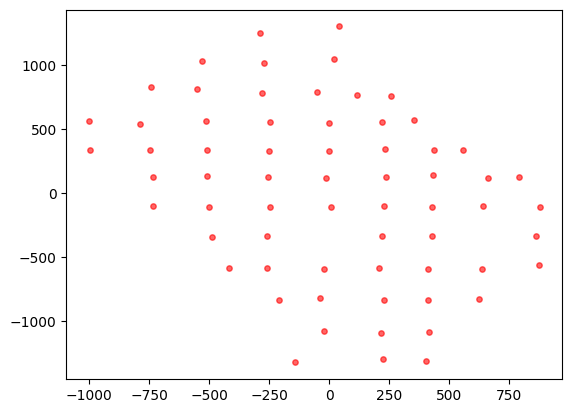

In [13]:

plt.scatter(point_representations[:,0], point_representations[:,1], marker='o',s=15,c='red',alpha=0.6)

/var/folders/nv/977slvsn2dl1t3jmdlwyn8w00000gn/T/ipykernel_6243/263107921.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


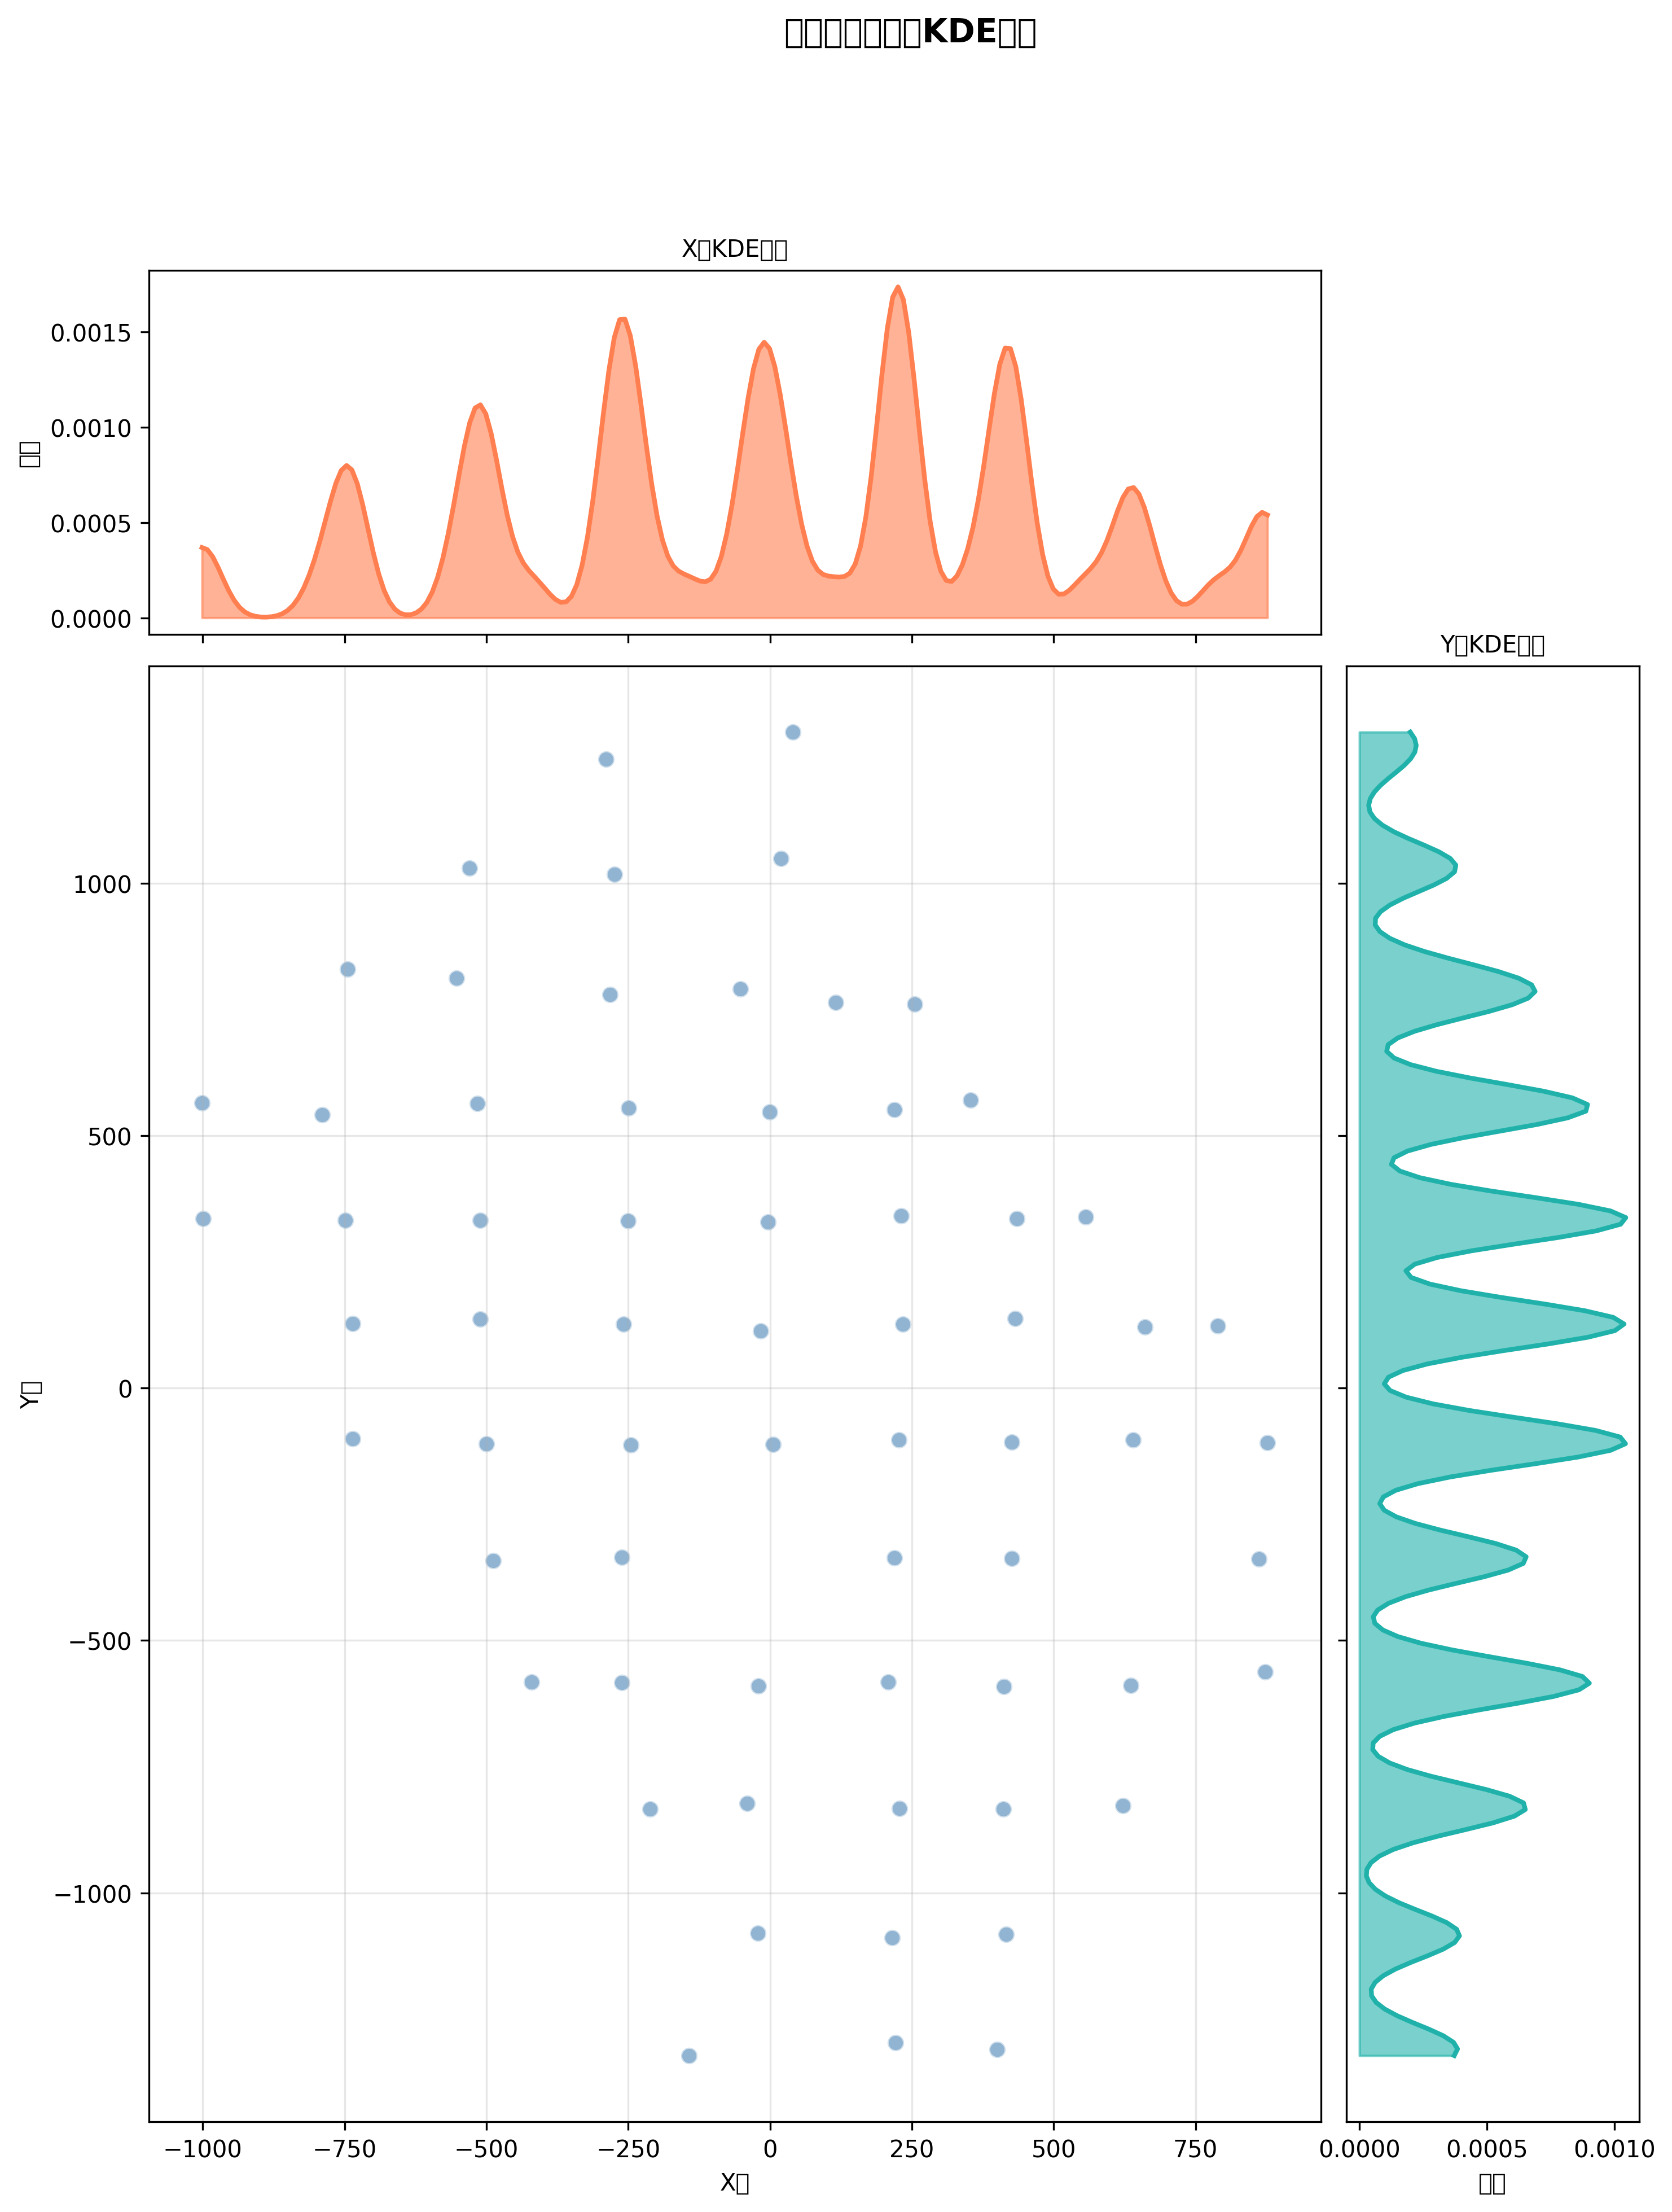

In [17]:
# 创建图形布局
fig = plt.figure(figsize=(12, 15),dpi=300)
gs = fig.add_gridspec(3, 3, width_ratios=[4, 1, 0.2], height_ratios=[1, 4, 0.2],hspace=0.05, wspace=0.05)

# 主散点图
ax_scatter = fig.add_subplot(gs[1, 0])
# x轴KDE
ax_kde_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
# y轴KDE
ax_kde_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# 手动计算KDE
def plot_custom_kde(data, ax, orientation='horizontal', color='steelblue'):
    """手动绘制KDE图"""
    kde = stats.gaussian_kde(data,bw_method=0.07)
    x_range = np.linspace(min(data), max(data), 200)
    y_kde = kde(x_range)
    
    if orientation == 'horizontal':
        ax.fill_between(x_range, y_kde, alpha=0.6, color=color)
        ax.plot(x_range, y_kde, color=color, linewidth=2)
        ax.set_ylabel('密度')
    else:
        ax.fill_betweenx(x_range, y_kde, alpha=0.6, color=color)
        ax.plot(y_kde, x_range, color=color, linewidth=2)
        ax.set_xlabel('密度')

# 绘制散点图
ax_scatter.scatter(x=point_representations[:,0], y=point_representations[:,1], s=50, alpha=0.6, color='steelblue', edgecolor='white')
ax_scatter.set_xlabel('X轴')
ax_scatter.set_ylabel('Y轴')
ax_scatter.grid(True, alpha=0.3)

# 绘制x轴KDE
plot_custom_kde(point_representations[:,0], ax_kde_x, 'horizontal', 'coral')
ax_kde_x.tick_params(axis='x', labelbottom=False)
ax_kde_x.set_title('X轴KDE分布', fontsize=10)

# 绘制y轴KDE
plot_custom_kde(point_representations[:,1], ax_kde_y, 'vertical', 'lightseagreen')
ax_kde_y.tick_params(axis='y', labelleft=False)
ax_kde_y.set_title('Y轴KDE分布', fontsize=10)

# 添加统计信息文本框
# stats_text = f'数据统计:\n点数: {n_points}\nX均值: {np.mean(x):.2f}\nY均值: {np.mean(y):.2f}\n相关系数: {np.corrcoef(x, y)[0,1]:.3f}'
# ax_scatter.text(0.02, 0.98, stats_text, transform=ax_scatter.transAxes, 
#                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('自定义散点图与KDE分布', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()